Abhängigkeiten

In [ ]:
%pip install torch
%pip install transformers
%pip install -U scikit-learn

Laden des Modells

In [ ]:
from transformers import BertConfig, BertForSequenceClassification, AutoTokenizer
import torch

# Laden der Konfiguration
# Ersetze den Pfad durch den lokalen Pfad zum config Verzeichnis
config_path = 'models\model_epoch3_lr2e-05_bs16_scheduler_20240109-020252\epoch_3'
config = BertConfig.from_pretrained(config_path, output_hidden_states=False)

# Laden des Tokenizers
model_name = 'ahmedrachid/FinancialBERT'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Erstellen des Modells
model = BertForSequenceClassification(config)

# Laden der Gewichte
model_weights = 'models\model_epoch3_lr2e-05_bs16_scheduler_20240109-020252\epoch_3\pytorch_model.bin'  # Replace with your model weights file
model.load_state_dict(torch.load(model_weights))

# Setze das Modell in den Evaluationsmodus
model.eval()

Laden der Testdaten

In [2]:
import sqlite3
from sklearn.model_selection import train_test_split

# Verbindung zur Datenbank herstellen
conn = sqlite3.connect('data/sentiment.db')
cursor = conn.cursor()

# Abrufen der Daten aus der Tabelle "sentences"
cursor.execute("SELECT sentence_text, final_sentiment FROM sentences WHERE final_sentiment != 'manual'")
data = cursor.fetchall()

# Schließen der Datenbankverbindung
conn.close()

# Konvertiere die Daten in ein Dictionary mit den Schlüsseln "text" und "label"
data = [{"text": text, "label": label} for text, label in data]

# konvertiere bullish zu 0, neutral zu 1 und bearish zu 2
data = [{"text": row["text"], "label": 0 if row["label"] == "bullish" else 1 if row["label"] == "neutral" else 2} for row in data]

# Teile die Daten in Trainings-, Test- und Validierungssets auf
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

# Gib die Größen der Trainings-, Test- und Validierungssets aus
print("Train data percentage:", (round((len(train_data) / len(data)) * 100)))
print("Test data percentage:", (round((len(test_data) / len(data)) * 100)))
print("Validation data percentage:", (round((len(val_data) / len(data)) * 100)))

Train data percentage: 72
Test data percentage: 15
Validation data percentage: 13


Tokenisierung

In [3]:
from transformers import AutoTokenizer
import torch

# Funktion, um die Daten zu tokenisieren
def tokenize_data(data):
    tokenized_data = []
    for item in data:
        # Tokenisiere den Text und füge das Ergebnis dem Array hinzu
        encoding = tokenizer(
            item['text'],
            padding='max_length',  # Pad kürzere Sätze
            truncation=True,       # Schneide längere Sätze ab
            max_length=512,        # Maximale Länge auf BERT's limit setzen
            return_tensors='pt'    # Rückgabe als PyTorch Tensoren
        )
        tokenized_data.append({'input_ids': encoding['input_ids'].squeeze(0), 'attention_mask': encoding['attention_mask'].squeeze(0), 'label': item['label']})
    return tokenized_data

# Tokenisiere Trainings-, Test- und Validierungsdaten
train_data_tokenized = tokenize_data(train_data)
val_data_tokenized = tokenize_data(val_data)
test_data_tokenized = tokenize_data(test_data)

Erstellen von DataLoadern

In [4]:
from torch.utils.data import Dataset

# Erstelle eine benutzerdefinierte Dataset-Klasse
class SentimentDataset(Dataset):
    def __init__(self, tokenized_data): # Konstruktor
        self.tokenized_data = tokenized_data

    def __len__(self): # Anzahl der Daten
        return len(self.tokenized_data)

    def __getitem__(self, idx): # Gibt einen Datenpunkt zurück
        return self.tokenized_data[idx]

train_dataset = SentimentDataset(train_data_tokenized)
val_dataset = SentimentDataset(val_data_tokenized)
test_dataset = SentimentDataset(test_data_tokenized)

In [5]:
from torch.utils.data import DataLoader

batch_size = 16

# Erstelle DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Errechnen der Metriken

In [10]:
import evaluate
from sklearn.metrics import f1_score

# Überprüfen, ob CUDA verfügbar ist und eine GPU zuweisen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Modell auf die GPU verschieben

model.eval()  # Schalte das Modell in den Evaluierungsmodus

total_eval_accuracy = 0
total_eval_loss = 0

# Lade die Metriken
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

 # Listen für wahre Labels und Vorhersagen
true_labels = []
preds = []

for batch in test_loader:  # Verwende den Test-DataLoader
    # Übertrage die Batch-Daten auf das richtige Device (z.B. GPU)
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():  # Deaktiviere die Gradientenberechnung für die Evaluation
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    # Konvertiere die Ausgaben des Modells in Vorhersagen
    logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]
    predictions = torch.argmax(logits, dim=-1)

    # Sammle wahre Labels und Vorhersagen für Metrikberechnung
    preds.extend(predictions.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

    # Aktualisiere die Metriken mit den Vorhersagen und den wahren Labels
    accuracy_metric.add_batch(predictions=predictions, references=labels)
    f1_metric.add_batch(predictions=predictions, references=labels)
    precision_metric.add_batch(predictions=predictions, references=labels)
    recall_metric.add_batch(predictions=predictions, references=labels)
    
    # Berechne den Verlust und akkumuliere den Gesamtverlust.
    loss = outputs.loss
    total_eval_loss += loss.item()

f1 = f1_score(true_labels, preds, average='weighted')

# Berechne die durchschnittliche Verlust über alle Testbatches
avg_test_loss = total_eval_loss / len(test_loader)
print("Test Loss: ", avg_test_loss)

# Berechne die finale Metrik
final_accuracy = accuracy_metric.compute()
final_f1 = f1_metric.compute(average="weighted")  # oder andere Durchschnittswerte je nach Bedarf
final_precision = precision_metric.compute(average="weighted")
final_recall = recall_metric.compute(average="weighted")

print("Accuracy:", final_accuracy)
print("F1-Score:", final_f1)
print("F1-Scikit:", f1)
print("Precision:", final_precision)
print("Recall:", final_recall)

Test Loss:  0.27967330950183517
Accuracy: {'accuracy': 0.9153129161118508}
F1-Score: {'f1': 0.9157232231476383}
F1-Scikit: 0.9157232231476383
Precision: {'precision': 0.9174974844709703}
Recall: {'recall': 0.9153129161118508}


Errechnen der Konfusionsmatrix

In [6]:
from sklearn.metrics import confusion_matrix
import numpy as np

true_labels_list = []
predictions_list = []

for batch in test_loader:
    inputs, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['label']
    inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        # Hier bekommen wir die Logits (die Rohausgabe des Modells vor der Anwendung der Aktivierungsfunktion).
        logits = outputs.logits  # oder outputs[0], abhängig vom Modell

        # Bestimme die Klasse mit der höchsten Score für jede Eingabe im Batch
        _, predictions = torch.max(logits, dim=1)

    # Sammle die wahren Labels und die Vorhersagen
    true_labels_list.extend(labels.cpu().numpy())
    predictions_list.extend(predictions.cpu().numpy())

# Nachdem alle Vorhersagen gesammelt sind, konvertiere Listen in Arrays
true_labels = np.array(true_labels_list)
predictions = np.array(predictions_list)


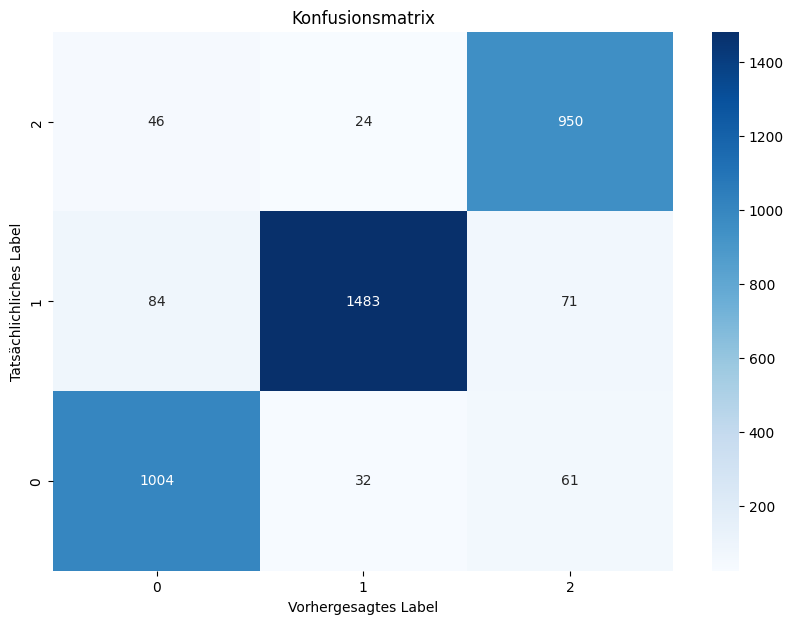

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Berechne die Konfusionsmatrix
cm = confusion_matrix(true_labels, predictions)

# Umdrehen der Matrix, so dass die Klasse 0 unten links ist
cm_flipped = np.flipud(cm)

# Visualisiere die umgedrehte Konfusionsmatrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_flipped, annot=True, fmt="d", cmap='Blues')
plt.title("Konfusionsmatrix")
plt.xlabel('Vorhergesagtes Label')
plt.ylabel('Tatsächlichliches Label')

# Korrigiere die y-Achsen-Beschriftungen
# plt.yticks() nimmt zwei Argumente: Die Positionen und die Labels der Ticks
# Wir stellen die Positionen so ein, dass sie auf die Mitte der Kästen zeigen
plt.yticks(np.arange(0.5, len(cm)), labels=np.arange(len(cm))[::-1])

plt.show()

Classification Report

In [ ]:
from sklearn.metrics import classification_report

# true_labels: Die tatächlichen Labels aus dem Testset
# predictions: Vorhersagen des Modells

report = classification_report(true_labels, predictions, target_names=['bullish', 'neutral', 'bearish'])
print(report)
